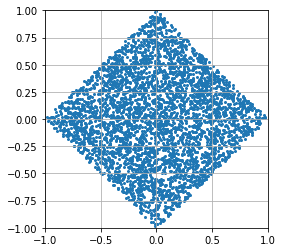

In [2]:
# 
# Non independent random variable pair with covariance = 0
#
#   E[X] = E[Y] = E[X + Y] = E[X - Y] = 0
#   Cov(X + Y, X - Y) = E[(X + Y)(X - Y)] = E[X^2 - Y^2] = E[X^2] - E[Y^2] = 0
#
# Such random variable appears after DFT as it can be seen from DFT recursion
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt

def _0():
    x = np.random.random(2**12) - 0.5 # uniform [-0.5, 0.5]
    y = np.random.random(2**12) - 0.5 # uniform [-0.5, 0.5]

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.grid()
    ax.set(xlim=[-1, 1], ylim=[-1, 1])
    ax.scatter(x + y, x - y, s=4)

    
def _1():
    ls0 = []
    ls1 = []
    for _ in range(2**12):
        N = 2
        a = np.random.random(N) - 0.5
        a_fft = np.fft.fft(a)
        ls0 += [a_fft[0].real]
        ls1 += [a_fft[N//2].real]

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.grid()
    ax.set(xlim=[-1, 1], ylim=[-1, 1])
    ax.scatter(ls0, ls1, s=4)

# _0()
_1()

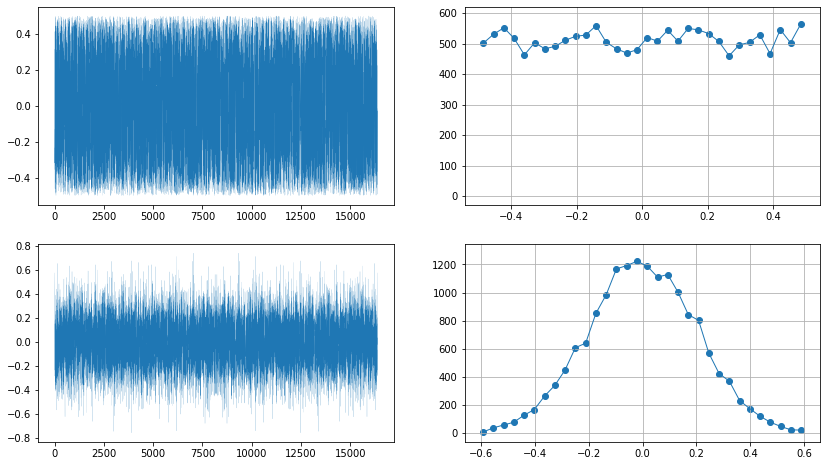

In [3]:
#
# Fourier transform doesn't preserve uniform iid
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import pydash as pyd


# Histogram based on average and std
def plot_hist(f, bins=2**5, n=3, range=None, ax=None):
    if range is None:
        range = np.average(f) + n * np.std(f) * Np([-1, 1])
    hist, bin_edges = np.histogram(f, bins=bins, range=range)
    dx = bin_edges[1] - bin_edges[0]

    if ax is None:
        fig, ax = plt.subplots()
    ax.set(ylim=np.max(hist) * Np([-0.05, 1.1]))
    ax.grid()
    ax.scatter(bin_edges[:-1] + dx / 2, hist)
    ax.plot(bin_edges[:-1] + dx / 2, hist, linewidth=1)

def _():
    N = 2**14
    a = np.random.random(N) - 0.5      # [-0.5, 0.5] iid
    a_fft = np.fft.fft(a) / np.sqrt(N)

    fig, axes = plt.subplots(2, 2, figsize=(7 * 2, 4 * 2))
    axes = pyd.flatten(map(list, axes))

    # Original uniform [-0.5, 0.5] iid
    axes[0].plot(np.arange(N), a, linewidth=0.1)
    plot_hist(a, range=[-0.5, 0.5], ax=axes[1])

    # DFT result
    axes[2].plot(np.arange(N), a_fft.real, linewidth=0.1)
    plot_hist(a_fft.real, n=3, ax=axes[3])


_()

In [4]:
#
# Correct scaling to make DFT as isometric (i.e. Regard DFT as approx of Fourier series L^2[0, X] <-> l^2(Z))
#

import numpy as np;  Np = np.array

# fft
def _0():
    N = 2**8
    X = N
    f = np.random.random((N, N))
    F = np.fft.fft2(f)

    dim = 2
    isometric_coeff = (np.sqrt(X) / N)**dim
    F *= isometric_coeff

    assert np.allclose(np.sum(f**2), np.sum((np.conj(F) * F).real))
    
# ifft
def _1():
    N = 2**8
    X = N
    f = np.random.random((N, N))
    F = np.fft.ifft2(f)

    dim = 2
    isometric_coeff = (np.sqrt(X) / N)**dim
    F /= isometric_coeff

    assert np.allclose(np.sum(f**2), np.sum((np.conj(F) * F).real))    

_0()
_1()

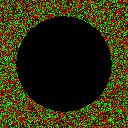

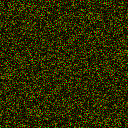

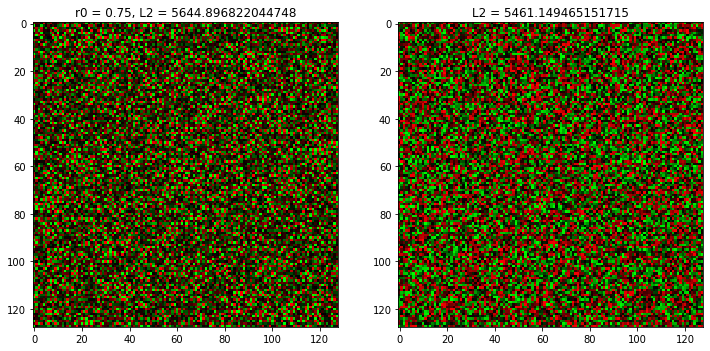

In [5]:
#
# Noise without lower frequency
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import PIL.Image

def to_pillow(a, gamma=False):
    if gamma:
        a = a**(1/2.2)
    a_bytes = np.clip(a * 2**8, 0, 2**8 - 1).astype(np.uint8)
    return PIL.Image.fromarray(a_bytes)

def to_signed_heatmap(a):
    return np.stack([np.fmax(a, 0), np.fmax(-a, 0), np.zeros_like(a)]).T


def _():
    N = 2**7
    X = N
    f = np.random.random((N, N)) # in [0, 1]
    f = f_orig = f * 2 - 1                # in [-1, 1]

    # Zero out low frequency entries
    t = np.linspace(-1, 1, num=N)
    x, y = np.meshgrid(t, t)
    r = np.sqrt(x**2 + y**2)
    r0 = 0.75                                 # highpass filter at r0 * N / 2
    f = f * (r0 < r)                          # zero out
    f = f * np.sqrt(4 / (4 - np.pi * r0**2))  # compensate lost L2 norm
    
    # Follow frequency entry order convention
    g = np.roll(f, (N // 2, N // 2), axis=(0, 1))

    F = np.fft.fft2(g)
    F = F * (np.sqrt(X) / N)**2  # L2/l2 isometric scaling

    display(to_pillow(to_signed_heatmap(f)))    
    display(to_pillow(to_signed_heatmap(F.real)))

    fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 6))
    ax = axes[0]
    ax.set(title=f"r0 = {r0}, L2 = {np.sum(F.real**2 * 2)}")
    ax.imshow(to_pillow(to_signed_heatmap(F.real * np.sqrt(2))))
    ax = axes[1]
    ax.set(title=f"L2 = {np.sum(f_orig**2)}")
    ax.imshow(to_pillow(to_signed_heatmap(f_orig)))

_()

[L1] 8193.00998308643 8171.346914806562 8213.71934914292
[L2] 4550.328404871914 5456.014924791889 6302.975350667139


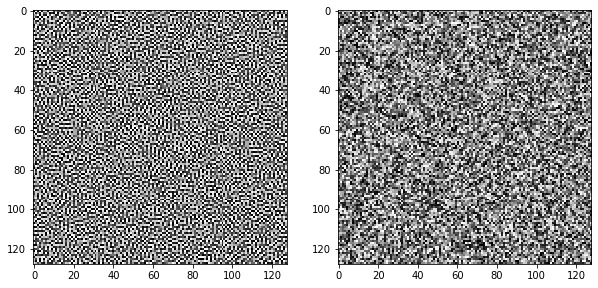

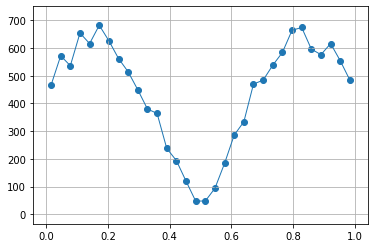

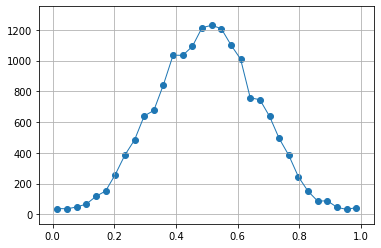

In [6]:
#
# Noise without lower frequency (contd.)
#
import numpy as np;  Np = np.array
import matplotlib.pyplot as plt

# Histogram based on average and std
def plot_hist(f, bins=2**5, n=3, range=None, ax=None):
    if range is None:
        range = np.average(f) + n * np.std(f) * Np([-1, 1])
    hist, bin_edges = np.histogram(f, bins=bins, range=range)
    dx = bin_edges[1] - bin_edges[0]

    if ax is None:
        fig, ax = plt.subplots()
    ax.set(ylim=np.max(hist) * Np([-0.05, 1.1]))
    ax.grid()
    ax.scatter(bin_edges[:-1] + dx / 2, hist)
    ax.plot(bin_edges[:-1] + dx / 2, hist, linewidth=1)


# Linear map [mu - n_std, mu + n_std] -> [0, 1] and clipping
def to_unit(f, n=3):
    mu = np.average(f)
    n_std = n * np.std(f)
    f = 0.5 + (f - mu) / (2 * n_std)
    return np.clip(f, 0, 1)


def inverse_tent(f):
    return np.sign(f - 0.5) * np.abs(f - 0.5)**(1/2) + 0.5


def _(r0=0.5):
    N = 2**7
    X = N
    f = f_orig = np.random.random((N, N)) # in [0, 1]
    f = f * 2 - 1                         # in [-1, 1]

    # Zero out low frequency entries
    t = np.linspace(-1, 1, num=N)
    x, y = np.meshgrid(t, t)
    r = np.sqrt(x**2 + y**2)
    f = f * (r0 < r)                          # highpass filter at r0 * N / 2
    f = f * np.sqrt(4 / (4 - np.pi * r0**2))  # compensate lost L2 norm
    
    # Follow frequency entry order convention
    g = np.roll(f, (N // 2, N // 2), axis=(0, 1))

    F = np.fft.fft2(g)
    F = F * (np.sqrt(X) / N)**2   # L2/l2 isometric scaling
    F_unit = to_unit(F.real, n=3) # in [0, 1] by linear map and clipping
    F_unit_tent = inverse_tent(F_unit)  # bend distribution to make it closer to uniform

    print("[L1]", np.sum(F_unit), np.sum(f_orig), np.sum(F_unit_tent))
    print("[L2]", np.sum(F_unit**2), np.sum(f_orig**2), np.sum(F_unit_tent**2))

    fig, axes = plt.subplots(1, 2, figsize=(5 * 2, 5))
    ax = axes[0]
    ax.imshow(F_unit_tent, cmap='gray', vmin=0, vmax=1)
    ax = axes[1]
    ax.imshow(f_orig, cmap='gray', vmin=0, vmax=1)
    plot_hist(F_unit_tent, range=[0, 1])
    plot_hist(F_unit, range=[0, 1])


_(r0=0.8)

In [7]:
import functools
@functools.lru_cache(None)
def download_image(url):
    import requests, io
    import PIL.Image
    resp = requests.get(url)
    image = PIL.Image.open(io.BytesIO(resp.content))
    return Np(image).astype(np.float) / 255

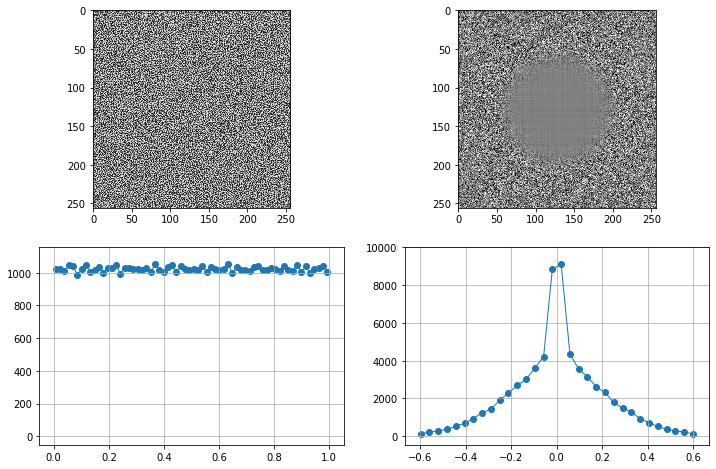

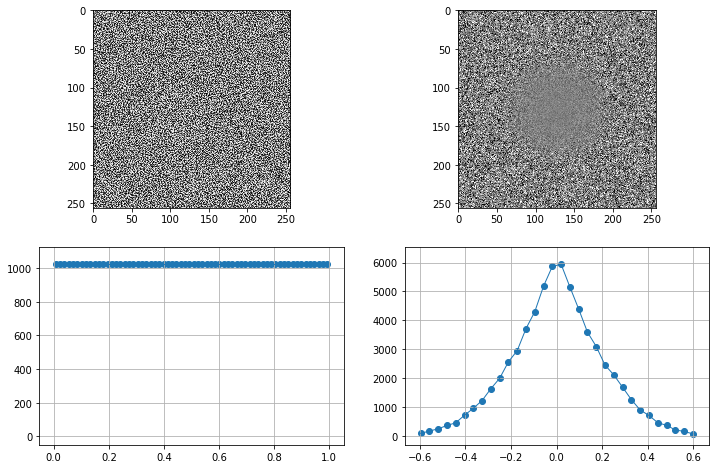

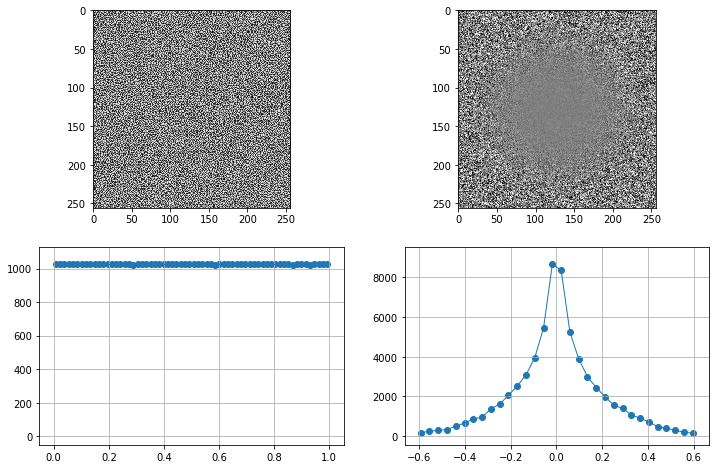

In [12]:
#
# Noise without lower frequency (contd.)
#
import pydash as pyd
import PIL.Image


def _0(a, N):
    a_fft = np.fft.fft2(a - 0.5) / N
    a_fft = np.roll(a_fft, (N // 2, N // 2), axis=(0, 1))
    a_fft = a_fft.real

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(6 * 2, 4 * 2))
    axes = pyd.flatten(map(list, axes))
    ax = axes[0]
    ax.imshow(a, cmap='gray', vmin=0, vmax=1)
    ax = axes[1]
    ax.imshow(a_fft, cmap='gray', vmin=-0.5, vmax=0.5)
    plot_hist(a, bins=2**6, range=[0, 1], ax=axes[2])
    plot_hist(a_fft, ax=axes[3])


def _1(name):
    url = dict(
        shadertoy='https://www.shadertoy.com/media/a/cb49c003b454385aa9975733aff4571c62182ccdda480aaba9a8d250014f00ec.png',
        bartwronski='https://raw.githubusercontent.com/bartwronski/BlueNoiseGenerator/master/Output/output_256x256_uni.bmp',
    )[name]
    a = download_image(url)
    N = 2**8
    a = a[:N, :N, 0]
    _0(a, N)
    
def _2(file, N=2**8):
    image = PIL.Image.open(file)
    a = Np(image)[:N, :N, 0]
    a = a.astype(np.float) / 255
    _0(a, N)


_1(name='shadertoy')
_1(name='bartwronski')
_2('../../python-shader-app/shaders/images/ex41_blue_noise_generator.png')

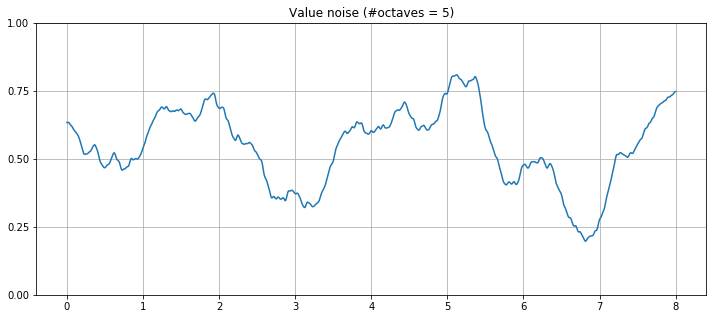

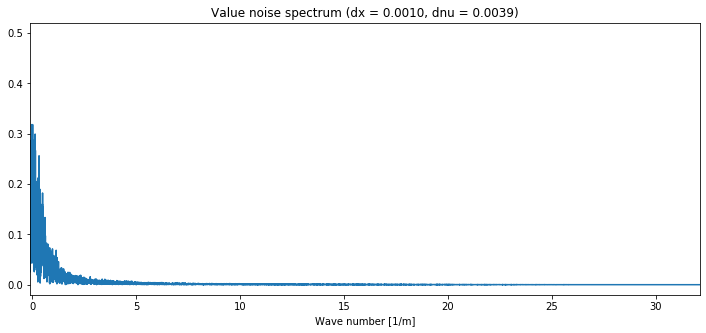

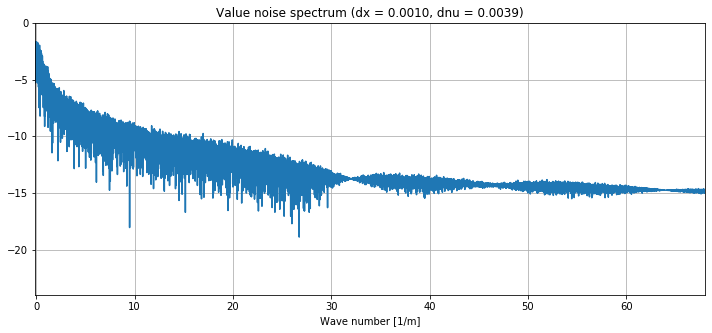

In [2]:
#
# Spectrum of noise
#
# TODO:
# - [x] Fourier transform artificial noise with octaves
#   - value noise might have some unusual "bias" (i.e. cubic factor at integer lattice)
# - [x] Fourier transform from random frequency distribution
# - [x] blue noise
# - [x] Analyze 2d noise
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def smoothstep(x):
    x = np.clip(x, 0, 1)
    return (-2 * x + 3) * x * x

def fract(x):
    return x - np.floor(x)


def value_noise(x, seed=0):  # -> in [0, 1] with avg = 0.5
    # 3rd-smooth interpolation of uniform random (aka value noise)
    npr = np.random.default_rng(seed)
    xi = np.floor(x).astype(np.int)
    xf = x - xi
    xi_hash = npr.random(np.max(xi) + 2)
    f0 = xi_hash[xi]
    f1 = xi_hash[xi + 1]
    t = smoothstep(xf)
    f = (1 - t) * f0 + t * f1
    return f


def value_noise_octave(x, num_octaves, seed=0):  # -> in [0, 1] with avg = 0.5
    y = value_noise(x, seed=seed)
    N = num_octaves
    for p in range(1, N + 1):
        s = 2**p  # scale
        t = p*p + 1 / s # translate
        y += value_noise(s * x + t) / s
    y /= ((2**(N+1) - 1) / 2**N)
    return y


def _0(num_octaves=5, seed=21):
    xlim = (0, 2**3)
    num = 2**10  # => dx = 1 / 2**7

    x = np.linspace(*xlim, num=num)
    y = value_noise_octave(x, num_octaves, seed=seed)

    _, ax = plt.subplots(figsize=(12, 5))
    ax.set(ylim=[0, 1], yticks=np.arange(4 + 1) / 4,
           title=f"Value noise (#octaves = {num_octaves})")
    ax.grid()
    ax.plot(x, y)


def _1(num_octaves=5, seed=21, log_plot=True):
    xlim = (0, 2**8)  # need wide interval to get finer "dnu" below
    N = 2**18
    X = xlim[1] - xlim[0]
    dx = X / N
    dnu = 1 / X

    x = np.linspace(*xlim, num=N, endpoint=False)
    y = value_noise_octave(x, num_octaves, seed=seed)  # in [0, 1]
    y += - 0.5  # in [-0.5, 0.5] with avg = 0

    F = np.fft.fft(y)
    P = np.sqrt(np.real(F)**2 + np.imag(F)**2)
    # TODO:
    # - not sure if `sqrt` is mathematically "nice" since Fourier series's coefficient
    #   is a component of l^2 vector space
    # P = np.real(F)**2 + np.imag(F)**2

    # Translate/Scale to treat DFT as an approximation of Fourier series
    nu = np.arange(-N/2, N/2) * dnu  # wave number
    P = np.fft.fftshift(P) * np.sqrt(X) / N

    _, ax = plt.subplots(figsize=(12, 5))
    ax.set(xlabel=f"Wave number [1/m]",
           title=f"Value noise spectrum (dx = {dx:.4f}, dnu = {dnu:.4f})")    
    if log_plot:
        ax.set(xlim=[-0.1, 2**6 + 4], ylim=[-24, 0])
        ax.grid()
        ax.plot(nu, np.log2(P))
        # TODO: it should have slope of about `- log2(2) = -1` ?
        # ax.plot(nu, - 0.1 * (nu - 20) - 10)
        
    else:
        ax.set(xlim=[-0.1, 2**5 + 0.1], ylim=[-0.02, 0.52],
               xlabel=f"Wave number [1/m]",
               title=f"Value noise spectrum (dx = {dx:.4f}, dnu = {dnu:.4f})")
        ax.plot(nu, P)

_0()
_1(log_plot=False)
_1(log_plot=True)

# UI
# ipyw.interact(_0, num_octaves=(0, 7), seed=(0, 2**8))
# ipyw.interact(_1, num_octaves=(0, 7), seed=(0, 2**8))

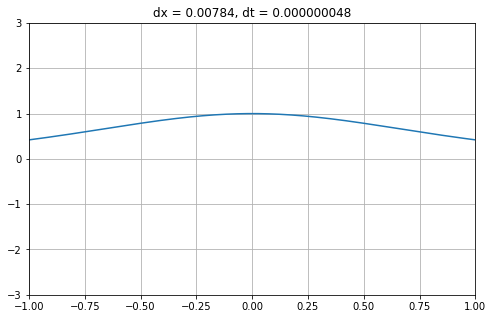

In [84]:
#
# KdV: (d/dt f) = - ((d/dx)^3 f) + 6 f (d/dx f)
#
# TODO: obviously, this trivial approach doesn't work...
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def integrate(dt, dx, dt_over_dx3, f):
    # Periodic boundary
    fp1 = np.roll(f, -1)
    fp2 = np.roll(f, -2)
    fn1 = np.roll(f, +1)
    fn2 = np.roll(f, +2)

    # Dx1_f = (fp1 - fn1) / (2 * dx)
    # Dx3_f = ((fp2 - fn2) - 2 * (fp1 - fn1)) / (2 * dx**3)
    # Dt_f = - Dx3_f + 6 * f * Dx1_f
    # f = f + dt * Dt_f
    # return f
    
    f += dt_over_dx3 * dx**2 * (fp1 - fn1) / 2
    f += dt_over_dx3 * ((fp2 - fn2) - 2 * (fp1 - fn1)) / 2
    return f
    

def _(t=0.0):
    xlim = (-1, 1)
    ylim = (-3, 3)
    x = np.linspace(*xlim, num=2**8)
    dx = x[1] - x[0]
    
    # Initial value
    f0 = (1 / np.cosh(x))**2

    # Integrate
    dt_over_dx3 = 0.1
    dt = dt_over_dx3 * dx**3
    t_sim = 0
    f = f0
    while True:
        if t_sim > t: break
        f = integrate(dt, dx, dt_over_dx3, f)
        t_sim += dt

    # Plotting
    _, ax = plt.subplots(figsize=(8, 5))
    ax.set(xlim=xlim, ylim=ylim, title=f"dx = {dx:.5f}, dt = {dt:.9f}")
    ax.grid()
    ax.plot(x, f)
    
_()

# ipyw.interact(_, t=(0, 1, 0.001))

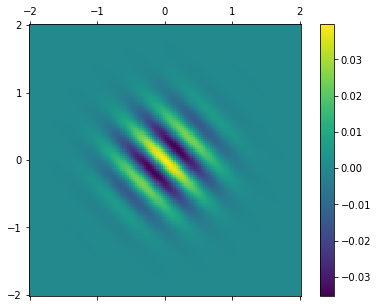

In [61]:
#
# 2D Wave packet
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def unit_gaussian_ufunc(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x*x/2)


def wave_packet_2d(x, y, k_dir, k_mu, k_sigma, use_analytic=False, use_fft=False):
    # @param
    #   x: float(N, M)  (as in np.meshgrid)
    #   y: float(N, M)    
    # @return
    #   f: float(N, M)

    kx_mu = k_mu * np.cos(k_dir * 2 * np.pi)
    ky_mu = k_mu * np.sin(k_dir * 2 * np.pi)
    kxlim = kx_mu + 5 * k_sigma * Np([-1, 1])
    kylim = ky_mu + 5 * k_sigma * Np([-1, 1])

    if use_analytic:
        # Fourier inverse of 
        #   unit_gaussian_ufunc((kx - kx_mu) / k_sigma) / k_sigma)
        #   unit_gaussian_ufunc((ky - ky_mu) / k_sigma) / k_sigma)
        inv_x = np.exp(1j * kx_mu * x) * unit_gaussian_ufunc(x * k_sigma) / k_sigma
        inv_y = np.exp(1j * ky_mu * y) * unit_gaussian_ufunc(y * k_sigma) / k_sigma
        return inv_x * inv_y

    if use_fft:
        assert False, 'Not implemented'
    
    # Straight forward computation
    kx = np.linspace(*kxlim, num=2**6, dtype=np.float32)  # float(L)
    ky = np.linspace(*kylim, num=2**6, dtype=np.float32)
    dkx = kx[1] - kx[0]
    dky = ky[1] - ky[0]
    kx, ky = np.meshgrid(kx, ky)  # kx, ky : float(L, L)

    gaussian_kx = unit_gaussian_ufunc((kx - kx_mu) / k_sigma) / k_sigma  # float(L, L)
    gaussian_ky = unit_gaussian_ufunc((ky - ky_mu) / k_sigma) / k_sigma

    # Inverse Fourier
    x = x[..., np.newaxis, np.newaxis]  # float(N, M, 1, 1)
    y = y[..., np.newaxis, np.newaxis]
    tmp = np.exp(1j * (kx * x + ky * y)) * gaussian_kx * gaussian_ky  # float(N, M, L, L)
    f_x = (1 / (2 * np.pi)) * dkx * dky * np.sum(tmp, axis=(2, 3))
    return f_x


def make_extent(xlim, ylim, dx, dy):
    x_ext = Np(xlim) + 0.5 * dx * Np([-1, 1])
    y_ext = Np(ylim) + 0.5 * dy * Np([-1, 1])
    return [*x_ext, *y_ext]


def tmp_matshow(ax, t, f):
    dt = t[1] - t[0]
    lim = [t[0], t[-1]]
    extent = make_extent(lim, lim, dt, dt)
    ax.xaxis.tick_bottom()
    cb = ax.matshow(f, origin='lower', extent=extent)
    return cb


def _(k_dir=1/8, k_mu=2 * (2 * np.pi), k_sigma=2):
    t = np.linspace(-2, 2, num=2**7, dtype=np.float32)
    x, y = np.meshgrid(t, t)
    f = wave_packet_2d(x, y, k_dir, k_mu, k_sigma, use_analytic=True)
    f = np.real(f)

    fig, ax = plt.subplots(figsize=(7, 5))
    cb = tmp_matshow(ax, t, f)
    fig.colorbar(cb)    


_()

# UI
# ipyw.interact(_, k_dir=(-1.0, 1.0, 0.125), k_mu=(0.01, 100, 0.5), k_sigma=(0.01, 10, 0.1))

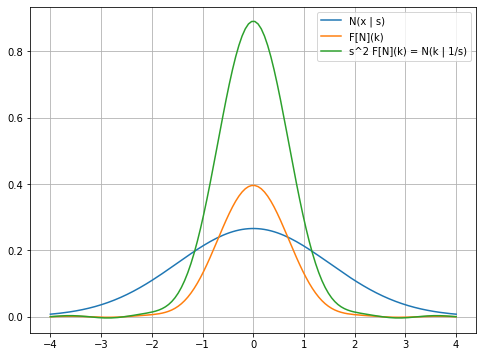

In [21]:
#
# Fourier transform of gaussian
#
#   F[N(x | s)](k) = F[1/s * N(x/s)](k)
#                  = 1/s   * F[N(x)](s k)
#                  = 1/s   * N(s k)
#                  = 1/s^2 * N(k | 1/s) 
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def unit_gaussian_ufunc(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x*x/2)


def fourier_transform(x, fx):
    # @params
    #   x : float(N)
    #   fx: float(N)
    # @returns
    #   k : float(N)
    #   Fk: float(N)
    dx = x[1] - x[0]
    k = x.reshape((-1, 1))  # float(N, 1)
    tmp = np.exp(-1j * k * x) * fx  # float(N, N)
    Fk = (1 / np.sqrt(2 * np.pi)) * dx * np.sum(tmp, axis=1) # float(N, N)
    return k, Fk


def _(sigma=1.5):
    x = np.linspace(-4, 4, num=2**7)
    fx = unit_gaussian_ufunc(x / sigma) / sigma
    k, Fk = fourier_transform(x, fx)
    gk = sigma**2 * np.real(Fk)  # = N()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid()
    ax.plot(x, fx,          label='N(x | s)')
    ax.plot(k, np.real(Fk), label='F[N](k)')
    ax.plot(k, gk, label='s^2 F[N](k) = N(k | 1/s)')
    ax.legend()

_(sigma=1.5)

# UI
# ipyw.interact(_, sigma=(0.1, 4, 0.1))

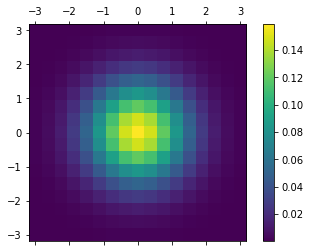

In [60]:
#
# Matplotlib matshow ticks
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def unit_gaussian_ufunc(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x*x/2)

def make_extent(xlim, ylim, dx, dy):
    x_ext = Np(xlim) + 0.5 * dx * Np([-1, 1])
    y_ext = Np(ylim) + 0.5 * dy * Np([-1, 1])
    return [*x_ext, *y_ext]

def _():
    t = np.linspace(-3, 3, num=2**4 + 1)
    x, y = np.meshgrid(t, t)
    z = unit_gaussian_ufunc(x) * unit_gaussian_ufunc(y)

    fig, ax = plt.subplots(figsize=(6, 4))

    dt = t[1] - t[0]
    lim = [t[0], t[-1]]
    extent = make_extent(lim, lim, dt, dt)
    ax.xaxis.tick_bottom()
    cb = ax.matshow(z, origin='lower', extent=extent)
    fig.colorbar(cb)
    
_()

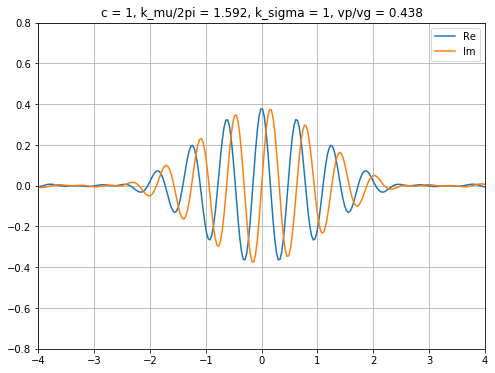

In [89]:
#
# Gaussian wave packet
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw

def unit_gaussian_ufunc(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x*x/2)

def _(t=0, eta=7.5, c=1, k_mu=10, k_sigma=1):
    #
    # Non-zero drag wave equation
    #   (D_t)^2 f = - 2 eta (D_t) f + c^2 (D_x)^2 f
    #
    # Fourier transformed solution is
    #   (D_t)^2 F = - 2 eta (D_t) F - (c k)^2 F
    #   => F = exp(-eta t) exp(+- i ((ck)^2 - (eta)^2)^{1/2} t) F0
    #
    # Here, we ignore decay factor "exp(-eta t)" for visalization purpose.
    #

    klim = k_mu + 2 * Np([-k_sigma, k_sigma])
    if c * (k_mu - 2 * k_sigma) < eta:
        print(f"[warn] klim = {klim}, k_mu = {k_mu}, k_sigma = {k_sigma}")
    k = np.linspace(*klim, num=2**8)
    dk = k[1] - k[0]
    gaussian_k = unit_gaussian_ufunc((k - k_mu) / k_sigma) / k_sigma

    # Inverse Fourier
    xlim = (-4, 4)
    x = np.linspace(*xlim, num=2**8)
    xx = x.reshape((-1, 1))
    f_xk = np.exp(1j * k * xx) * gaussian_k * np.exp(- 1j * np.sqrt((c * k)**2 - eta**2) * t)
    f_x = (1 / np.sqrt(2 * np.pi)) * dk * np.sum(f_xk, axis=1)
    # Hide decay factor for visualization purpose
    # f_x *= np.exp(-eta * t)
    
    # Ratio (phase velocity / group velocity)
    vp_over_vg = 1 - (eta / (k_mu * c))**2
    
    # Plotting
    ylim = (-0.8, 0.8)
    _, ax = plt.subplots(figsize=(8, 6))
    ax.set(xlim=xlim, ylim=ylim, title=f"c = {c}, k_mu/2pi = {k_mu / (2 * np.pi):.3f}, k_sigma = {k_sigma}, vp/vg = {vp_over_vg:.3f}")
    ax.grid()
    ax.plot(x, np.real(f_x), label=f"Re")
    ax.plot(x, np.imag(f_x), label=f"Im")    
    ax.legend()


_()

# UI
# ipyw.interact(_, t=(-10.0, 100, 0.1), eta=(0.0, 10, 0.05), c=(0.01, 10, 0.1), k_mu=(0.01, 100, 0.5), k_sigma=(0.01, 10, 0.1))

### Decoupling 1st order method

Starting from a wave equation:

$
(\partial_t)^2 f = c^2 (\partial_x)^2 f,
$

writing $g = (\partial_t) f$ and $h = (\partial_x) f$, we obtain:

$
\begin{align}
\partial_t g &= c^2 \partial_x h \\
\partial_t h &= \partial_x g
\end{align},
$

Or, using vector notation,

$
\partial_t \!
\begin{pmatrix}
g \\
h 
\end{pmatrix}
=
\begin{pmatrix}
0 & c^2 \\
1 & 0
\end{pmatrix}
\partial_x \!
\begin{pmatrix}
g \\
h
\end{pmatrix}.
$

Further, by noting diagonalization of the matrix,

$
\begin{pmatrix}
0 & c^2 \\
1 & 0
\end{pmatrix}
= P 
\begin{pmatrix}
c &  0 \\
0 & -c
\end{pmatrix}
P^{-1},
$

where 

$
P =
\begin{pmatrix}
c &  c \\
1 & -1
\end{pmatrix}
\quad
P^{-1} = 
\frac{1}{2c}
\begin{pmatrix}
1 &  c \\
1 & -c
\end{pmatrix},
$

and writing

$
\begin{pmatrix}
u \\
v
\end{pmatrix}
= P^{-1}
\begin{pmatrix}
g \\
h
\end{pmatrix},
$

we finally obtain two advection equations:

$
\begin{align}
\partial_t u &= +c \, \partial_x u \\
\partial_t v &= -c \, \partial_x v
\end{align}
.
$

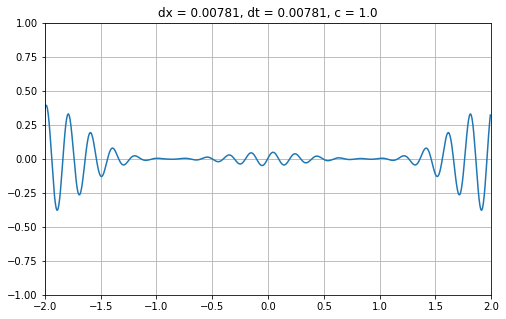

In [71]:
#
# Wave equation (Decoupling 1st order method)
#
# TODO: This looks quite performance, but it generates certain artifact.
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import itertools

def unit_gaussian_ufunc(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x*x/2) 

def wave_packet(x, c, k_mu, k_sigma):
    # @param
    #   x: float(N...)
    # @return
    #   f: float(N...)
    #   g: float(N...)
    klim = k_mu + 4 * k_sigma * Np([-1, 1])
    k = np.linspace(*klim, num=2**9)
    dk = k[1] - k[0]
   
    gaussian_k = unit_gaussian_ufunc((k - k_mu) / k_sigma) / k_sigma

    # Inverse Fourier
    x = x[..., np.newaxis]
    f_xk = np.exp(1j * k * x) * gaussian_k
    g_xk = np.exp(1j * k * x) * (-1j * c * k) * gaussian_k
    f_x = (1 / np.sqrt(2 * np.pi)) * dk * np.sum(f_xk, axis=1)    
    g_x = (1 / np.sqrt(2 * np.pi)) * dk * np.sum(g_xk, axis=1)
    return f_x, g_x


def finite_difference_center(dx, u):
    return  (np.roll(u, -1) - np.roll(u, +1)) / (2 * dx)


def integrate(dt, dx, u, v, c):
    e = dt * c / dx

    # Determine upwind/downwind so it's unconditionally stable
    u_up   = np.roll(u, -1)
    v_down = np.roll(v, +1)

    u = e * u_up   + (1 - e) * u
    v = e * v_down + (1 - e) * v
    return u, v


def _0(c=1.0, t=0.0):
    xlim = (-2, 2)
    ylim = (-1, 1)
    x = np.linspace(*xlim, num=2**9, endpoint=None)
    
    dx = x[1] - x[0]
    dt = dx / c  # this dt makes 2nd order cancellation of advection equation

    # Initial value
    f0, dt_f0 = wave_packet(x, c, 5 * (2 * np.pi), 3)
    f0, dt_f0 = np.real(f0), np.real(dt_f0)
    dx_f0 = finite_difference_center(dx, f0)

    # Basis change
    P =     lambda u, v: [c * (u + v),   u - v]
    inv_P = lambda g, h: [(g + c * h) / (2 * c),   (g - c * h) / (2 * c)]
    u0, v0 = inv_P(dt_f0, dx_f0)
    
    # Integrate
    t_sim = 0
    f, u, v = f0, u0, v0
    while True:
        dt_f, _ = P(u, v)
        f += dt * dt_f
        if t_sim > t: break
        u, v = integrate(dt, dx, u, v, c)
        t_sim += dt

    # Plotting
    _, ax = plt.subplots(figsize=(8, 5))
    ax.set(xlim=xlim, ylim=ylim, title=f"dx = {dx:.5f}, dt = {dt:.5f}, c = {c}")
    ax.grid()
    ax.plot(x, f)
    # [debug]
    # ax.plot(x, u, label=f"u")
    # ax.plot(x, v / 16, label=f"v")
    # ax.legend()


_0(t=2)

# UI
# ipyw.interact(_0, c=(0.0, 10, 0.1), t=(0.0, 10, 0.1))

### Approximation of implicit method

Given PDE first order in time,

$
\partial_t f(t, x) = L[f](t, x)
$

Assuming the operator $L$ has a linear finite difference approximation $A$, \
we can write "explicit method" and "implicit method" as below:

$
\begin{align}
\frac{\bar{f} - f}{\Delta_t} &= A \bar{f}  \; &\text{(implicit method)}
\\
\frac{\bar{f} - f}{\Delta_t} &= A f        \; &\text{(explicit method)}
\end{align}
$

where $\bar{f}$ denotes a "next step vector".

Thus, we obtain this relation for single step computation:

$
\begin{align}
\bar{f} &= (I - \Delta_t A)^{-1} f  \; &\text{(implicit method)}
\\
\bar{f} &= (I + \Delta_t A) f       \; &\text{(explicit method)}
\end{align}
$

By noting that when $\Delta_t \le \frac{1}{|A|}$ this power series converges:

$
(I - \Delta_t A)^{-1} = \sum_{n} (\Delta_t A)^n = I + \Delta_t A + \sum_{n \ge 2} (\Delta_t A)^n
$

From this, it's obvious that explicit method is nothing but an first order approximation of implicit method.

Thus, this canonically motivates "kth-approximate implicit method" as in:

$
\bar{f} = (\sum_{n <= k} (\Delta_t A)^n) f
$

Consistency of this method follows from the ones of implicit/explicit method by sandwitching. \
Stability of this method is to be investigated.

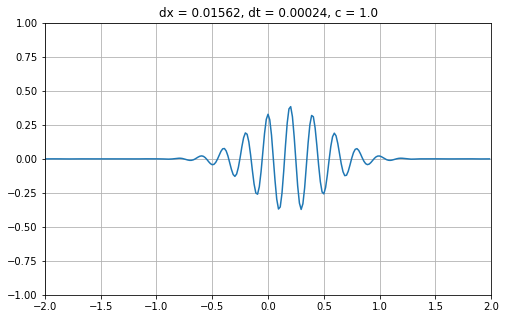

In [47]:
#
# Wave equation numerically
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def unit_gaussian_ufunc(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x*x/2) 


def wave_packet(x, c, k_mu, k_sigma):
    # @param
    #   x: float(N...)
    # @return
    #   f: float(N...)
    #   g: float(N...)
    klim = k_mu + 3 * k_sigma * Np([-1, 1])
    k = np.linspace(*klim, num=2**8)
    dk = k[1] - k[0]
   
    gaussian_k = unit_gaussian_ufunc((k - k_mu) / k_sigma) / k_sigma

    # Inverse Fourier
    x = x[..., np.newaxis]
    f_xk = np.exp(1j * k * x) * gaussian_k
    g_xk = np.exp(1j * k * x) * (-1j * c * k) * gaussian_k
    f_x = (1 / np.sqrt(2 * np.pi)) * dk * np.sum(f_xk, axis=1)    
    g_x = (1 / np.sqrt(2 * np.pi)) * dk * np.sum(g_xk, axis=1)
    return f_x, g_x


#
# Wave equation
#   - (d/dt)^2 f = c^2 (d/dx)^2 f
#   - with periodic boundary
#
# Writing g = d/dt f, we have 
#   - d/dt f = g
#   - d/dt g = c^2 (d/dx)^2 f
#
def integrate(dt, dx, t, f, g, c):
    # f: float(N)
    # g: float(N)
    # @return: float(N), float(N)
    
    # Periodic boundary
    fp1 = np.roll(f, -1)
    fn1 = np.roll(f, +1)

    e = c**2 * dt / dx**2
    ff = f + dt * g
    gg = g + e * (-2 * f + fp1 + fn1)
    return ff, gg

#
# From above, "finite approx operator" becomes
#   A = (  0, I)
#       (b B, 0)
#   where
#     b = (c/dx)^2
#     B = (-2, 1,   .. ,  1)
#         ( 1,-2, 1 .. ,  0)
#         ( ...            )
#         ( 1, ..     1, -2)
#
#
def integrate_approx_implicit(dt, dx, t, f, g, c, k):
    b = (c / dx)**2
    ff = f
    gg = g
    # Approximate power (assuming dt << 1, we can expect small k safices)
    for _ in range(k):
        fp1 = np.roll(f, -1)
        fn1 = np.roll(f, +1)        
        _f = dt * g
        _g = dt * b * (-2 * f + fp1 + fn1)
        f, g = _f, _g
        ff += f
        gg += g
    return ff, gg


def _0(c=1.0, t=0.0):
    xlim = (-2, 2)
    ylim = (-1, 1)
    x = np.linspace(*xlim, num=2**8, endpoint=None)
    
    # TODO: analyze stability and convergence
    dx = x[1] - x[0]
    dt = (dx / c)**2  # make "e = 1" in "integrate" defined above

    # Initial value
    # - rectangule function
    # f0 = np.clip(1 - abs(x), 0, 1)
    # g0 = np.zeros_like(f0)
    # - wave packet
    f0, g0 = wave_packet(x, c, 5 * (2 * np.pi), 3)
    f0, g0 = np.real(f0), np.real(g0)
    
    # Integrate
    t_sim = 0
    f, g = f0, g0
    while True:
        if t_sim > t: break
        # f, g = integrate(dt, dx, t_sim, f, g, c)
        f, g = integrate_approx_implicit(dt, dx, t_sim, f, g, c, k=2)
        t_sim += dt

    # Plotting
    _, ax = plt.subplots(figsize=(8, 5))
    ax.set(xlim=xlim, ylim=ylim, title=f"dx = {dx:.5f}, dt = {dt:.5f}, c = {c}")
    ax.grid()
    ax.plot(x, f)


_0(t=0.2)

# UI
# ipyw.interact(_0, c=(0.0, 10, 0.1), t=(0.0, 10, 0.1))

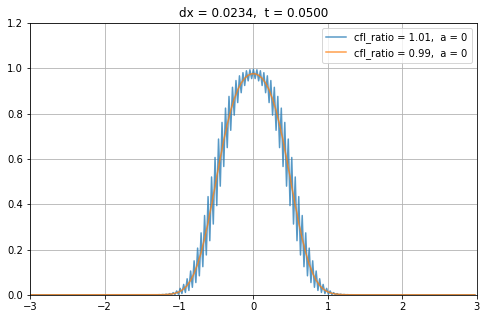

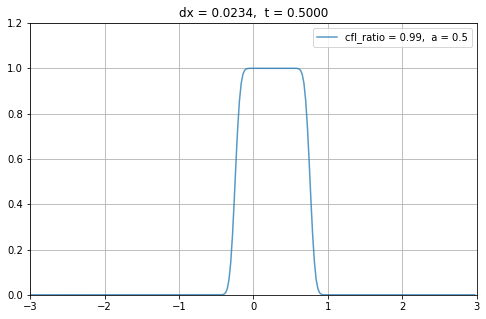

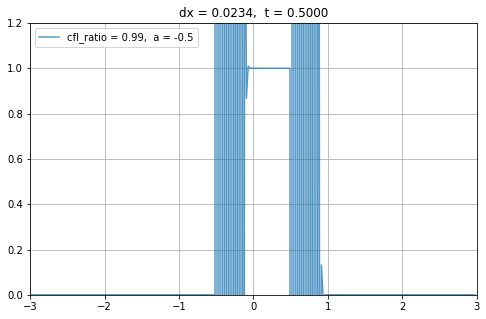

In [2]:
#
# Convection-diffusion equation numerically
# 

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


#
# Diffusion eq
# - d/dt = b (d/dx)^2
# - with dirichlet boundary
#
def integrate(dt, dx, t, f, a, b):
    # f: float(N)
    # @return: float(N)
    
    # CFL term
    e = dt * 2 * b / (dx**2)
    
    # Tri-diagonal matrix multiplication  ( .. e/2, 1 - e, e/2 .. )
    fp1 = np.concatenate([f[1:], [0]])
    fn1 = np.concatenate([[0], f[:-1]])
    g = - e * f + (e / 2) * (fp1 + fn1)   # diffusion term
    h = - dt * a * (f - fn1) / dx         # convection term
    return f + g + h


def _0(a=0.0, b=0.5, t=0.05, cfl_ratio=0.8):
    xlim = (-3, 3)
    ylim = (0, 1.2)

    x = np.linspace(*xlim, num=2**8, endpoint=None)
    dx = x[1] - x[0]
    
    def get_f(cfl_ratio):
        if b > 0:
            # Define dt based on CFL term
            dt_cfl = dx**2 / (2 * b)
            dt = cfl_ratio * dt_cfl
        else:
            dt_something = abs(dx / a)
            dt = 0.5 * dt_something
        
        # Rectangule initial value
        f = np.heaviside(0.5 - abs(x), 0)
        t_sim = 0

        while True:
            if t_sim > t: break
            f = integrate(dt, dx, t_sim, f, a, b)
            t_sim += dt
        
        return f

    ls = []
    for cfl_ratio in Np([cfl_ratio]).reshape(-1):
        ls += [(get_f(cfl_ratio), cfl_ratio)]

    _, ax = plt.subplots(figsize=(8, 5))
    ax.set(xlim=xlim, ylim=ylim, title=f"dx = {dx:.4f},  t = {t:.4f}")
    ax.grid()
    for f, cfl_ratio in ls:
        ax.plot(x, f, label=f"cfl_ratio = {cfl_ratio},  a = {a}", alpha=0.75)
    ax.legend()

#
# Compare when "CFL ratio" is above/below one
#
_0(a=0, cfl_ratio=[1.01, 0.99])
    
    
#
# Compare when convection goes right/left
#
_0(a=+0.5, b=0, t=0.5, cfl_ratio=0.99)
_0(a=-0.5, b=0, t=0.5, cfl_ratio=0.99)
    
# UI
# ipyw.interact(_0, a=(0.0, 10, 0.1), b=(0.01, 10), t=(0.0, 2, 0.01), cfl_ratio=(0.1, 10, 0.05))

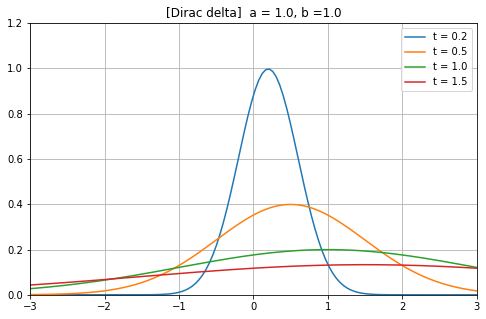

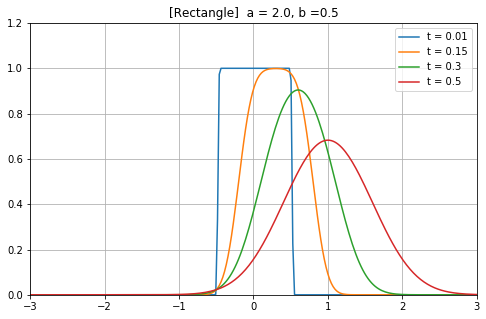

In [71]:
#
# Numerical integration (PDE)
#
# - [x] heat kernel solution (aka fundamental solution)
# - [x] heat kernel convolution with rectangle function
# - [@] numerical integration
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw

#
# Convection-diffusiong equation
# - d/dt = -a d/dx + b (d/dx)^2
# - f(t0, x) = f0(x)
#  => f(t, x) = N(x | E = at, Var = 2bt) <conv> f0(x)
# 
# NOTE:
#  - N(x | at, 2bt) = 1/sqrt(2pi) * invF[exp((-iak - bkk)t)](x)
#  - a [m/s]
#  - b [m^2/s]
#

def unit_gaussian_ufunc(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

def gaussian_ufunc(x, mu, sigma):
    return unit_gaussian_ufunc((x - mu) / sigma) / sigma

def heat_kernel_ufunc(x, a, b, t):
    mu = a * t
    sigma = 2 * b * t
    return gaussian_ufunc(x, mu, sigma)

def convolve_rectangle(x, ufunc, num=2**7):
    # x:      float(N ..)
    # ufunc:  float(M) -> float(M)
    # @return float(N ..)
    y = np.linspace(-0.5, 0.5, num, endpoint=False)  # float(M)
    dy = 1 / num
    xy = x[..., np.newaxis] + y                      # float(N .., M)
    f = ufunc(xy)                                    # float(N .., M)
    g = dy * np.sum(f, axis=-1)                      # float(N ..)
    return g

#
# Plot fundamental solution (i.e. solution for initial value f(0, x) = dirac-delta(x))
#
def _0(a=1.0, b=1.0, t=0.1):
    xlim = (-3, 3)
    ylim = (0, 1.2)
    x = np.linspace(*xlim, num=2**7)
    ls_t = Np([t]).reshape(-1)
    ls_tf = []
    for t in ls_t:
        f = heat_kernel_ufunc(x, a, b, t)
        ls_tf += [(t, f)]
    
    _, ax = plt.subplots(figsize=(8, 5))
    ax.set(xlim=xlim, ylim=ylim, title=f"[Dirac delta]  a = {a}, b ={b}")
    ax.grid()
    for t, f in ls_tf:
        ax.plot(x, f, label=f"t = {t}")
    ax.legend()
    
#
# Plot solution for rectangule function as initial value
#
def _1(a=1.0, b=0.5, t=0.01):
    xlim = (-3, 3)
    ylim = (0, 1.2)
    x = np.linspace(*xlim, num=2**8)
    ufunc = lambda x: heat_kernel_ufunc(x, a, b, t)
    ls_t = Np([t]).reshape(-1)    
    ls_tf = []
    for t in ls_t:
        f = convolve_rectangle(x, ufunc, num=2**8)
        ls_tf += [(t, f)]
    
    _, ax = plt.subplots(figsize=(8, 5))
    ax.set(xlim=xlim, ylim=ylim, title=f"[Rectangle]  a = {a}, b ={b}")
    ax.grid()
    for t, f in ls_tf:
        ax.plot(x, f, label=f"t = {t}")
    ax.legend()


_0(a=1.0, b=1.0, t=[0.2, 0.5, 1.0, 1.5])
_1(a=2.0, b=0.5, t=[0.01, 0.15, 0.3, 0.5])

# UI
# ipyw.interact(_0, a=(0.0, 10), b=(0.1, 10), t=(0.1, 10))
# ipyw.interact(_1, a=(0.0, 10), b=(0.01, 10), t=(0.01, 10))

In [7]:
#
# Numerical integration (spring pendulum)
#
# - bake and plot position
# - real time animation
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import matplotlib.animation as plt_animation


J = Np([
    0, 0,+1, 0,
    0, 0, 0,+1,
   -1, 0, 0, 0,
    0,-1, 0, 0,]).reshape((4, 4))


def f_impl(t, qp, m, k, l, g):
    # H = K + V where
    #   K(p) = |p|^2 / 2m
    #   V(q) = m g q_y + 1/2 k (r - l)^2
    qx, qy, px, py = qp
    r = np.linalg.norm([qx, qy])
    gradH = Np([
        k * (r - l) * qx / r,
        k * (r - l) * qy / r + m * g,
        px / m,
        py / m,])
    return J @ gradH

    
# 2nd order explicit (ODE define by y' = f(x, y))
def integrate(dx, x, y, f):
    return y + dx * f(x + dx/2, y + dt/2 * f(x, y))

# 4th explicit Runge-Kutta
def integrate_rg(dx, x, y, f):
    k1 = f(x           , y                )
    k2 = f(x + 1/2 * dx, y + 1/2 * dx * k1)
    k3 = f(x + 1/2 * dx, y + 1/2 * dx * k2)
    k4 = f(x + 1   * dx, y + 1   * dx * k3)
    y = y + dx * (1/6 * k1 + 2/6 * k2 + 2/6 * k3 + 1/6 * k4)
    return y


# Constants
k = 10            # [N / m]
m = 0.1           # [kg]
l = 0.5           # [m]
g = 9.8           # [N / kg]

# ODE model
f = lambda t, qp: f_impl(t, qp, m, k, l, g)

# Initial value
t0 = 0  # [s]
qp0 = Np([0, -l, 0.1, 0])  # [m], [m], [momentum], [momentum]

# State setup
total_t = 10
dt = 1/60
num_iter = int(total_t / dt)
t = t0
qp = qp0
ls_t = [t]
ls_qp = [qp]


# Integrate
for _ in range(num_iter):
    qp = integrate(dt, t, qp, f)
    t = t + dt
    ls_t += [t]
    ls_qp += [qp]
    
ls_t  = Np(ls_t)
ls_qp = Np(ls_qp)


def plot_parts(n, k=50, fig=None):
    ls_q = ls_qp[n:n+k, :2]
    ls_x = ls_q[:, 0]
    ls_y = ls_q[:, 1]
    assert ls_x[-1] is not None
    
    x = ls_x[-1]
    y = ls_y[-1]
    r = np.linalg.norm([x, y])

    if fig:
        ax = fig.subplots()
    else:
        _, ax = plt.subplots(figsize=(8, 6))
    ax.axis('equal')
    ax.set(xlim=[-1, 1], ylim=[-1, 0])
    ax.grid()
    ax.plot([0, x], [0, y], linewidth=1 / r)                # rubberband
    ax.scatter(ls_x, ls_y, c=k - np.arange(k), cmap='gray') # mass trajectory with trail


# UI
# %matplotlib inline
# ipyw.interact(n=ipyw.IntText(1, step=10), fig=ipyw.Checkbox(False))(plot_parts)


def save_anim(fig, plot_iterator, outfile, fps, dpi=100):
    writer = plt_animation.FFMpegWriter(fps=fps)
    with writer.saving(fig, outfile, dpi):
        for _ in plot_iterator:
            writer.grab_frame(blit=True)


def make_anim(outfile):
    plt.matplotlib.use('Agg')
    fig = plt.figure()
    fig.set_size_inches((8, 6))
    k = 50
    fps = int(1/dt)
    N = fps * 5
    def generator():
        for n in range(N - k):
            fig.clear()
            plot_parts(n, k, fig=fig)
            yield None            
    save_anim(fig, generator(), outfile, fps)


# Video
# make_anim(outfile='tmp.mp4')
# !totem tmp.mp4
# !rm tmp.mp4


def realtime_anim(dt_sim=0.001):
    import time, types
    from PySide2 import QtCore, QtGui, QtWidgets, QtCharts
    QtCharts = QtCharts.QtCharts

    state = types.SimpleNamespace(t=t0, qp=qp0, t_app=0, dt_app=None, t_epoch=None)
    
    # integrate with given dt_sim
    def update_state_v2():
        # Setup dt
        now = time.time()
        if state.t_epoch is None:
            state.t_epoch = now
        state.dt_app = now - state.t_epoch
        state.t_epoch = now
        state.t_app += state.dt_app
        
        # Integrate with dt_sim
        while True:
            if state.t_app < (state.t - t0) + dt_sim:
                break
            state.qp = integrate_rg(dt_sim, state.t, state.qp, f)
            state.t += dt_sim

    # integrate with qt timer's dt
    def update_state():
        # Setup dt
        now = time.time()
        if state.t_epoch is None:
            state.t_epoch = now
        state.dt_app = now - state.t_epoch
        state.t_epoch = now
        state.t_app += state.dt_app
        
        # Integration
        state.qp = integrate_rg(state.dt_app, state.t, state.qp, f)
        state.t += state.dt_app
        
    def create_chart(serieses, xlim, ylim):
        axis_x = QtCharts.QValueAxis()
        axis_x.setRange(*xlim)
        axis_y = QtCharts.QValueAxis()
        axis_y.setRange(*ylim)

        chart = QtCharts.QChart()
        chart.legend().hide()
        chart.addAxis(axis_x, QtCore.Qt.AlignTop)
        chart.addAxis(axis_y, QtCore.Qt.AlignLeft)
        for series in serieses:
            chart.addSeries(series)
            series.attachAxis(axis_x)
            series.attachAxis(axis_y)        
        return chart
    
    def run_qt():
        app = QtWidgets.QApplication.instance() or QtWidgets.QApplication()
        timer = QtCore.QTimer()

        series = QtCharts.QScatterSeries()
        series_line = QtCharts.QLineSeries()
        chart = create_chart([series, series_line], (-1, 1), (-1, 0))

        view = QtCharts.QChartView(chart)
        view.setRenderHint(QtGui.QPainter.Antialiasing)
        view.resize(400, 400)
        view.show()

        def timer_handler(*_):
            update_state_v2()
            x, y, px, py = state.qp
            r = np.linalg.norm([x, y])

            series.clear()
            series_line.clear()
            series.append(x, y)
            series_line.append(0, 0)
            series_line.append(x, y)
            chart.setTitle(f"t = {state.t:.3f}, dt = {state.dt_app:.3f}, dt_sim = {dt_sim}")

        timer.timeout.connect(timer_handler)
        timer.start(1000/60)
        app.exec_()

    run_qt()


# realtime_anim()

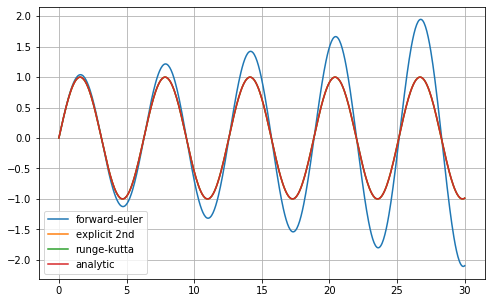

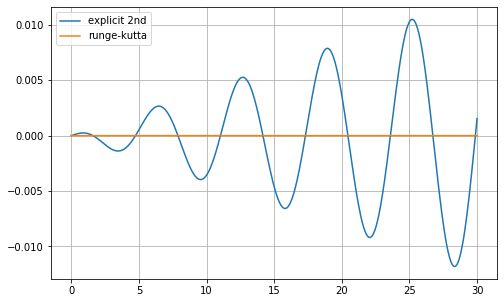

In [2]:
#
# Numerical integration (ODE: harmonic oscillator)
#

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

Np = np.array

def _(dt=0.01, total_t=20, plot_error=False, skip_euler=False):
    #
    # ODE: y' = f(x, y)
    #
    def f(x, y, m, k):
        A = Np([
             0, 1/m,
            -k,   0,
        ]).reshape((2, 2))
        return A @ y

    # Explicit 4th Runge-Kutta
    def runge_kutta(dx, x, y, *params):
        # Formulation in "Basic Concepts in Computational Physics"
        # y1 = y
        # y2 = y + dx/2 * f(x + 1/2 * dx, y1, *params)
        # y3 = y + dx/2 * f(x + 1/2 * dx, y2, *params)
        # y4 = y + dx   * f(x + 1   * dx, y3, *params)
        # z1 = 1/6 * f(x + 0   * dx, y1, *params)
        # z2 = 2/6 * f(x + 1/2 * dx, y2, *params)
        # z3 = 2/6 * f(x + 1/2 * dx, y3, *params)
        # z4 = 1/6 * f(x + 1   * dx, y4, *params)
        # y = y + dx * (z1 + z2 + z3 + z4)
        # return y
        
        # Formulation in Stoer, Bulirsch
        k1 = f(x           , y                , *params)
        k2 = f(x + 1/2 * dx, y + 1/2 * dx * k1, *params)
        k3 = f(x + 1/2 * dx, y + 1/2 * dx * k2, *params)
        k4 = f(x + 1   * dx, y + 1   * dx * k3, *params)
        y = y + dx * (1/6 * k1 + 2/6 * k2 + 2/6 * k3 + 1/6 * k4)
        return y
        

    k = 1             # [N / m]
    m = 1             # [kg]
    t0 = 0            # [s]
    qp0 = Np([0, 1])  # [m], [momentum]
    
    #
    # Numerical integration
    #
    num_iter = int(total_t / dt)
    t = t0
    qp = qp0
    qp_e2 = qp0
    qp_rg = qp0
    ls_t = [t]
    ls_qp = [qp]        # forward euler
    ls_qp_e2 = [qp_e2]   # explicit 2nd order
    ls_qp_rg = [qp_rg]  # runge kutta (explicit 4th order)

    for _ in range(num_iter):
        # forward euler
        qp = qp + dt * f(t, qp, m, k)
        
        # explicit 2nd 
        qp_e2 = qp_e2 + dt * f(t + dt/2, qp_e2 + dt/2 * f(t, qp_e2, m, k), m, k)        
        
        # runge kutta
        qp_rg = runge_kutta(dt, t, qp_rg, m, k)
        
        t = t + dt
        
        ls_t += [t]
        ls_qp += [qp]
        ls_qp_e2 += [qp_e2]
        ls_qp_rg += [qp_rg]

    #
    # closed form solution
    #
    w = np.sqrt(k / m)
    ls_q_analytic = qp0[0] * np.cos(w * Np(ls_t)) + qp0[1] / w * np.sin(w * Np(ls_t)) # = sin(t)

    #
    # Plotting
    #
    _, ax = plt.subplots(figsize=(8, 5))
    ax.grid()
    if plot_error:
        if not skip_euler:
            ax.plot(ls_t, Np(ls_qp)[:, 0]    - ls_q_analytic, label='forward-euler')
        ax.plot(ls_t, Np(ls_qp_e2)[:, 0] - ls_q_analytic, label='explicit 2nd')    
        ax.plot(ls_t, Np(ls_qp_rg)[:, 0] - ls_q_analytic, label='runge-kutta')    
        ax.legend()
    else:
        if not skip_euler:        
            ax.plot(ls_t, Np(ls_qp)[:, 0], label='forward-euler')
        ax.plot(ls_t, Np(ls_qp_e2)[:, 0], label='explicit 2nd')    
        ax.plot(ls_t, Np(ls_qp_rg)[:, 0], label='runge-kutta')    
        ax.plot(ls_t, ls_q_analytic,   label='analytic')
        ax.legend()


_(dt=0.05, total_t=30)
_(dt=0.05, total_t=30, plot_error=True, skip_euler=True)

# UI mode
# ipyw.interact(dt=ipyw.FloatText(0.05, step=0.001), total_t=ipyw.FloatText(30, step=1))(_)

In [35]:
#
# Matplotlib ffmpeg movie export (offscreen)
#

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as plt_animation

def _(outfile):
    plt.matplotlib.use('Agg')

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set(xlim=[-1, 1], ylim=[-1, 1], xlabel='x', ylabel='y')
    ax.grid()
    N = 24  # number of frames
    r = 0.9

    writer = plt_animation.FFMpegWriter(fps=4)
    with writer.saving(fig, outfile, 100):
        for i in range(N):
            t = np.array([i, i + 1]) / N * 2 * np.pi
            x = r * np.cos(t)
            y = r * np.sin(t)
            ax.plot(x, y ,color='C0')
            writer.grab_frame(blit=True)
            
    plt.close(fig)

# _(outfile='tmp.mp4')

# Play video e.g. by totem
# !totem tmp.mp4
# !rm tmp.mp4

In [9]:
#
# Matplotlib animation via FuncAnimation
#

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as plt_animation

def _(outfile=None):
    # cf. plt.matplotlib.rcsetup.all_backends
    plt.matplotlib.use('Qt5Agg' if outfile is None else 'Agg')

    K = 8
    delta = 0.05

    t = np.arange(K) + 0.5
    x, y = [_.reshape(-1) for _ in np.meshgrid(t, t)]
    xy = np.stack([x, y])

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xlim=[-0.1, 8.1], ylim=[-0.1, 8.1])
    ax.grid()
    scatter = ax.scatter(xy[0], xy[1], color='C0')
    
    def update_data(n, *_):
        u = np.random.random((2, K * K))  # in [0, 1]
        u = delta * (2 * u - 1)           # in [-delta, +delta]
        np.add(xy, u, out=xy)
        # TODO: decoration doesn't work for Qt5Agg backend
        ax.set(title=f"n = {n}")
        scatter.set_offsets(xy.T)
        return ax,
    
    if outfile is None:
        N = 48
        anim = plt_animation.FuncAnimation(fig, update_data, N, blit=True, repeat=True)
        plt.show()

    else:
        FPS = 24
        N = FPS * 4
        anim = plt_animation.FuncAnimation(fig, update_data, N, blit=False, repeat=False)
        anim.save(outfile, fps=FPS)

_()

# _(outfile='tmp.mp4')

# !totem tmp.mp4
# !rm tmp.mp4

In [4]:
#
# Quick wrapper to define container with default values
#

def _():
    from types import SimpleNamespace
    
    def define_struct(name, default):
        def init_impl(self, **kwargs):
            self.__dict__.update(default)
            self.__dict__.update(kwargs)
        return type(name, (SimpleNamespace,), dict(__init__=init_impl))

    class Ray(define_struct('Ray', dict(o=None, d=None, t_max=1e30))):
        pass
    
    print(Ray(o=[0, 0, 0], d=[1, 1, 1]))
    
_()    

Ray(d=[1, 1, 1], o=[0, 0, 0], t_max=1e+30)


In [21]:
#
# Wallis product
#

def _(k=10):
    import numpy as np
    a = 2 * np.arange(1, k)
    return 2 * np.prod((a * a) / ((a + 1) * (a - 1)))

_(k=5000000)

3.141592496522947

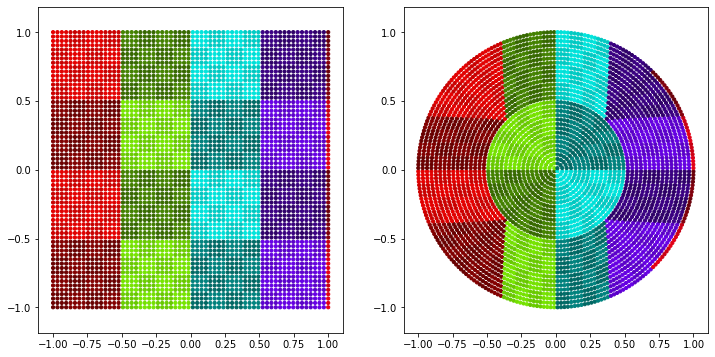

In [139]:
#
# constant density scale homeomorphism from [0, 1]^2 to D^2
# cf. Shirley, P., and K. Chiu. 1997. A low distortion map between disk and square.
#
# - [x] 2d-2d map visualization by color
# - [x] find homotopy (more importantly it's isotopy)
# - [-] is this related to some differential geometry construction?
#       (Lie transform method used for proving poincare lemma?)
# 

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

# for visualization
def _checker_fractal(n, m, b, p_max):
    x, y = np.meshgrid(np.arange(n), np.arange(m))    
    
    c = np.zeros((n, m), dtype=np.float)    
    for p in range(p_max + 1):
        k = b**p
        cx = x % (2 * k) >= k
        cy = y % (2 * k) >= k        
        c += (cx ^ cy) * k        
    c /= (b**(p_max + 1) - 1) / (b - 1)
    return c


def _1():
    # only 1/8 part { (x, y) | x in [0, 1], y in [0, x] }
    t = np.linspace(0, 1, num=2**4)
    x, y = [ _.reshape(-1) for _ in np.meshgrid(t, t) ] # x, y: float<m>    
    mask = y <= x
    x = x[mask]
    y = y[mask]

    radius = x
    theta = np.pi / 4 * y / x
    z = radius * np.cos(theta)
    w = radius * np.sin(theta)
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, y, s=16)
    ax.scatter(z, w, s=16)

    
def _2():
    # [-1, 1]^2
    t = np.linspace(0, 1, num=2**6) * 2 - 1
    x, y = [ _.reshape(-1) for _ in np.meshgrid(t, t) ] # x, y: float<m>
    
    sign_x = np.sign(x)
    sign_y = np.sign(y)
    abs_x = np.abs(x)
    abs_y = np.abs(y)
    
    xx = np.fmax(abs_x, abs_y)
    yy = np.fmin(abs_x, abs_y)
    swap = abs_y > abs_x
    
    radius = xx
    theta = np.pi / 4 * yy / xx
    zz = radius * np.cos(theta)
    ww = radius * np.sin(theta)
    
    z = sign_x * np.where(swap, ww, zz)
    w = sign_y * np.where(swap, zz, ww)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].axis('equal')
    axes[1].axis('equal')
    
    c = _checker_fractal(t.size, t.size, 4, 2).reshape(-1)  # float<m>
    c = np.interp(c, [0, 1], [0.4, 0.9])
    hue_n = 4
    hue = np.floor((x + 1) / 2 * hue_n) / hue_n # float<m>
    rgb = plt.cm.hsv(hue)[:, :3]                # float<m, 3>
    color = rgb * c.reshape((-1, 1))

    axes[0].scatter(x, y, s=10, c=color)
    axes[1].scatter(z, w, s=10, c=color)


def _3(p): # p in (0, 1)
    # homotopy (isotopy) via ellipse
    t = np.linspace(0, 1, num=2**4)[1:]
    x, y = [ _.reshape(-1) for _ in np.meshgrid(t, t) ] # x, y: float<m>    
    mask = y <= x
    x = x[mask]
    y = y[mask]

    # here `b` becomes major axis
    b = 1 / np.tan(np.arccos(p))
    radius = x
    theta = np.arctan(1 / b) * y / x
    z = radius * np.cos(theta)
    w = radius * b * np.sin(theta)
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.scatter(x, y, s=16)
    ax.scatter(z, w, s=16)    


# _1()
_2()
# _3(p=1 / np.sqrt(2))

# ipyw.interact(p=ipyw.FloatText(1 / np.sqrt(2), step=0.02))(_3)

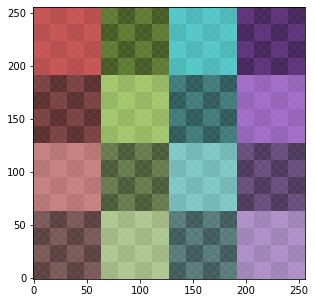

In [134]:
#
# Fractal(-ish) checker grid for uv visualization (cf. Blender's color grid)
#

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

def _hue(t): # t : float(?) -> float(?, 3)
    t = np.expand_dims(t, -1)
    v = np.array([0, 1, 2]) / 3
    d3 = np.abs(t - v)
    d3 = np.fmin(d3, 1.0 - d3)  # distance from three bumps
    height = 2.0
    slope  = 6.0
    return np.clip(height - slope * d3, 0, 1)

def _():
    n = 8
    t = np.arange(2**n)
    x, y = np.meshgrid(t, t)

    # checker sizes at the power of b with "1/f" weight
    b = 4
    m = 3
    checker = np.zeros(x.shape, dtype=np.float)
    for i in range(0, m + 1):
        k = b**i
        cx = x % (2 * k) >= k
        cy = y % (2 * k) >= k        
        checker += (cx ^ cy) * k
    checker /= (b**(m + 1) - 1) / (b - 1)
    
    # chromaticity steps along x
    chrom_n = 4
    chrom = np.floor((x * chrom_n) / t.size) / chrom_n
    rgb = _hue(chrom)  # or plt.cm.hsv(chrom)[:, :, :3]
    
    # saturation steps along y
    satur_n = 4
    satur = np.floor((y * satur_n) / t.size) / chrom_n
    # satur = y / t.size  # or saturation gradient along y
    
    # manual tonemap and combine
    checker = np.interp(checker, [0, 1], [0.1, 0.6]) 
    checker = checker**(1/2.2)
    checker = np.expand_dims(checker, -1)
    satur = np.interp(satur, [0, 1], [0.5, 0.05])
    satur = np.expand_dims(satur, -1)
    rgb = satur + (1 - satur) * rgb
    rgb = rgb**(1/2.2)
    color = rgb * checker
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(color, origin='lower')
    # ax.imshow(checker[:, :, 0], origin='lower', cmap='gray', vmin=0, vmax=1) 
    # ax.imshow(satur[:, :, 0], origin='lower', cmap='gray', vmin=0, vmax=1)

_()

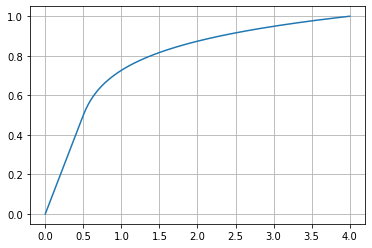

In [68]:
#
# log tonemapping
#

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

def _solve(p, q, max_iter=2**7, init_eps=1.0, debug=False):
    # assert 0 < b < c
    b = 1 - p
    c = q - p  

    #
    # Solve x > 0 s.t. g(x) = exp(b x) - c x - 1 = 0
    # - use Newton method
    # - initial value x0 is taken so that it won't converge to x = 0,
    #   which probably is guaranteed by g'(x0) = b exp(b x0) - c > 0
    #   i.e. x0 > log(c / b) / b
    #
    from math import log, exp
    
    x = log(c / b) / b + init_eps
    for _ in range(max_iter):
        g  = exp(b * x) - c * x - 1
        dg = b * exp(b * x) - c
        if debug:
            print(f"x: {x:.5f}, g: {g:.5f}")
        x = x - g / dg
        if abs(g) < 0.0000001:
            break
    return x


def _plot(p=0.5, q=4.0):
    assert p < 1.0  # knee low
    assert q > 1.0  # knee high
    t = np.linspace(0, q, num=2**7)

    #
    # diff-able conti. f s.t.
    # f(t) = (if      t <= p)  t   
    #        (if p <  t <= q)  p + (log(a (t - p) + 1)) / a
    #        (if q <  t     )  1
    #
    # here, trivially:
    #      f(p) = p
    #     f'(p) = (1 / a) * a = 1
    # but, 
    #      f(q) = p + (log(a (q - p) + 1)) / a = 1
    # this requires to solve a > 0 s.t.
    #      (q - p) a + 1 = exp((1 - p) a)
    # which unique/exist iff (1 - p) < (q - p)  (i.e. 1 < q)
    #
    a = _solve(p, q)
    y = np.empty_like(t)
    mask = t < p
    y[ mask] = t[mask]
    y[~mask] = p + np.log(a * (t[~mask] - p) + 1) / a

    # plot
    fig, ax = plt.subplots()
    ax.grid()
    ax.plot(t, y)

_plot()
# ipyw.interact(p=ipyw.FloatText(0.5, step=0.05), q=ipyw.FloatText(2.0, step=0.2))(_plot)

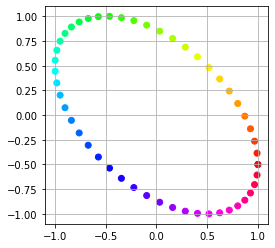

In [2]:
#
# wave with different phase
#

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

def _(p):
    t = np.linspace(0, 1)
    x = np.cos(2 * np.pi * t)
    y = np.cos(2 * np.pi * (t - p))

    _, ax = plt.subplots(figsize=(4, 4))
    ax.grid()
    lim = 1.1
    ax.set(xlim=[-lim, lim], ylim=[-lim, lim])
    ax.scatter(x, y, c=t, cmap='hsv')


_(1 / 3)
# ipyw.interact(p=ipyw.FloatText(1 / 3, step=0.05))(_)

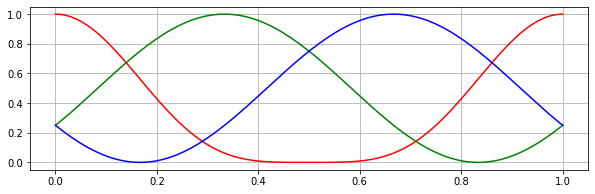

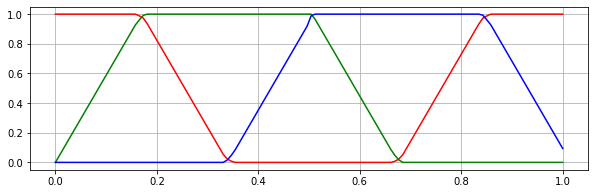

In [348]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

def _():
    def plot(r, g, b):
        _, ax = plt.subplots(figsize=(10, 3))
        ax.grid()
        ax.plot(t, r, color='r')
        ax.plot(t, g, color='g')
        ax.plot(t, b, color='b')

    def wave(t):
        r = 0.5 + 0.5 * np.cos(2 * np.pi * (t - 0/3))
        g = 0.5 + 0.5 * np.cos(2 * np.pi * (t - 1/3))
        b = 0.5 + 0.5 * np.cos(2 * np.pi * (t - 2/3))
        r = r**2
        return r, g, b
        
    def hsv(t):
        c = plt.cm.hsv(t)
        return c[:, 0], c[:, 1], c[:, 2]

    t = np.linspace(0, 1, num=2**7)
    plot(*wave(t))
    plot(*hsv(t))
    
_()

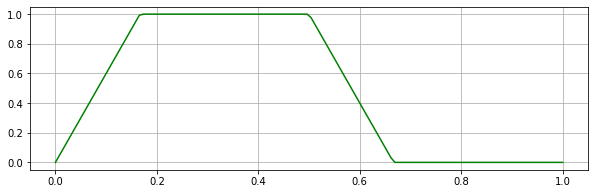

In [107]:
#
# HSV bump function
#

def _():
    # t: in [0, 1]
    # b: bump position
    # s: bump slope
    def bump(t, b, s):
        d = np.abs(t - b)
        d = s * np.fmin(d, 1 - d)
        return 2 - d

    t = np.linspace(0, 1, num=2**7)
    b = 1 / 3
    s = 6
    g = np.clip(bump(t, b, s), 0, 1)
    _, ax = plt.subplots(figsize=(10, 3))
    ax.grid()
    ax.plot(t, g, color='g')

_()

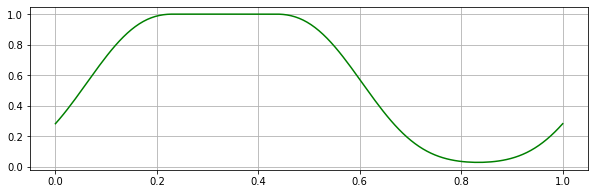

In [127]:
def _():
    def smoothstep(t0, t1, t):
        t = (t - t0) / (t1 - t0)
        t = np.clip(t, 0, 1)
        return (-2 * t + 3) * t * t
        
    def tweak(g):
        g = smoothstep(-0.1, 0.9, g)
        return g

    t = np.linspace(0, 1, num=2**7)
    g = 0.5 + 0.5 * np.cos(2 * np.pi * (t - 1/3))
    g = tweak(g)

    _, ax = plt.subplots(figsize=(10, 3))
    ax.grid()
    ax.plot(t, g, color='g')
    
_()